In [42]:
import numpy as np
from matplotlib import pyplot as plt

cnt = [0, 0, 0]


class GradientDescending():

    @staticmethod
    def grad(f, x, h=1e-5):
        cnt[0] += 1
        return (f(x[:, np.newaxis] + h * np.eye(x.size)) - f(x[:, np.newaxis] - h * np.eye(x.size))) / (2 * h)

    def one_dimension_method(self, func, x, direction, alpha, eps, max_iterations):
        return x + direction * alpha

    def find_min(self, func, initial, alpha=0.4, eps=1e-3, max_iterations=5000):
        cnt[0] = 0
        cnt[1] = 0
        cnt[2] = 0
        points = initial
        coords = initial
        for i in range(max_iterations):
            if i > 0:
                points = np.vstack((points, coords))
            direction = -self.grad(func, coords)
            next_coords = self.one_dimension_method(func, coords, direction, alpha, 1e-4, max_iterations)
            if np.max(np.abs(coords - next_coords)) < eps:
                return points
            coords = next_coords
        return points


class DichtGradientDescending(GradientDescending):
    def one_dimension_method(self, func, x, direction, alpha, eps, max_iterations):
        l = x
        r = x + direction*alpha
        d = eps
        for i in range(max_iterations):
            m = (l + r) / 2
            fl = func(m - direction * d)
            fr = func(m + direction * d)
            cnt[1] += 2
            if fl > fr:
                l = m - direction * d
            else:
                r = m + direction * d
            f = func(m)
            cnt[1] += 1
            if f <= fl and f <= fr:
                d /= 8
            delta = r - l
            if np.sqrt(delta.dot(delta)) < eps:
                break
        return r

class WolfGradientDescending(GradientDescending):
    c1 = 0.075
    c2 = 0.7

    def check_first(self, func, x, directions, l):
        cnt[1] += 2
        return func(x + l * directions) <= func(x) + l * self.c1 * np.dot(self.grad(func, x), directions)

    def check_second(self, func, x, directions, l):
        return np.dot(self.grad(func, x + l * directions), directions) >= self.c2 * np.dot(self.grad(func, x),
                                                                                           directions)

    def one_dimension_method(self, func, x, direction, alpha, eps, max_iterations):
        al = 0
        ar = 1
        while self.check_first(func, x, direction, ar):
            ar *= 2
        while ar - al > eps:
            a = (ar + al) / 2
            if self.check_first(func, x, direction, a):
                al = a
            else:
                ar = a
        al = 0
        while ar - al > eps:
            a = (al + ar) / 2
            if self.check_second(func, x, direction, a):
                ar = a
            else:
                al = a
        if not self.check_first(func, x, direction, ar) or not self.check_second(func, x, direction, ar):
            cnt[2] = 1
        return x + direction * ar

In [43]:
class QuadraticFunction:

    def __init__(self, diag_matrix: np.array):
        self.coeffs = np.array([diag_matrix[i][i]
                               for i in range(len(diag_matrix))], dtype=np.double)

    def __call__(self, args: np.array) -> float:
        return sum([np.power(args[i], 2) * self.coeffs[i] for i in range(len(args))])

    def __str__(self):
        result = ''
        for i in range(len(self.coeffs) - 1):
            result += f'{self.coeffs[i]:.5f}*x_{i}^2 + '
        result += f'{self.coeffs[-1]:.5f}*x_{len(self.coeffs) - 1}^2'
        return result
    
def generate(n: int, k: int) -> QuadraticFunction:
    diag_matrix = np.zeros((n, n))
    diag_matrix[0][0] = 1
    diag_matrix[1][1] = k
    for i in range(2, n):
        diag_matrix[i][i] = np.random.uniform(1, k)

    return QuadraticFunction(diag_matrix)

In [44]:
def g(x):
  return 2*(x[0] - 10)**2 + 0.2*(x[1] + 13)**2 + 3
  
def h(x):
  return (x[0] - 4)**2 + 100*(x[1] + 5)**2
  
def k(x):
  return 4*(x[0] - 1)**2 + 8*(x[1] + 3)**2 - 4

In [45]:
G = np.array([[2, 0], [0, 0.2]])
H = np.array([[1, 0], [0, 100]])
K = np.array([[4, 0], [0, 8]])
print(np.linalg.cond(G))
print(np.linalg.cond(H))
print(np.linalg.cond(K))

10.0
100.0
2.0


In [46]:
plt.rcParams["figure.figsize"] = (10, 10)

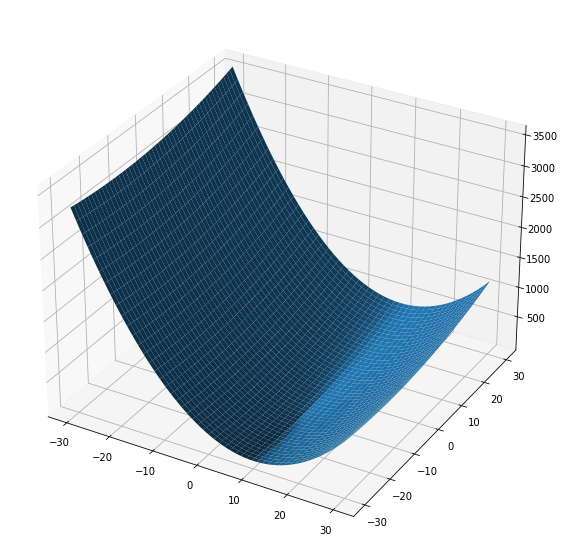

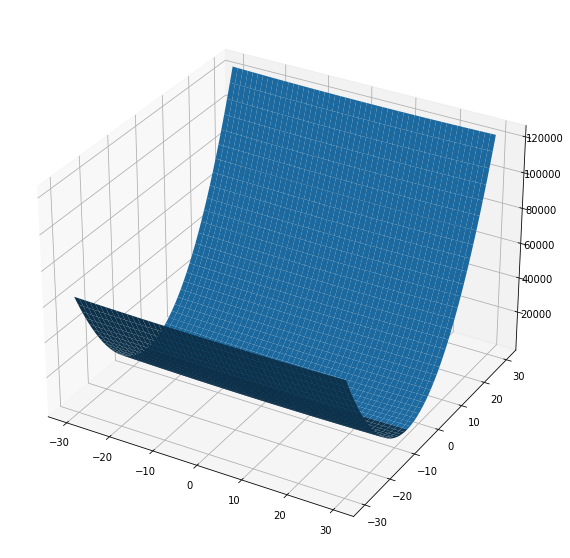

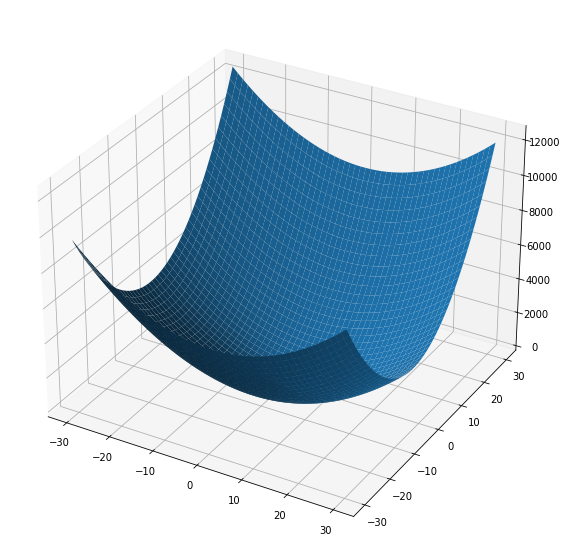

In [47]:
t = np.linspace(-30, 30, 1000)
X, Y = np.meshgrid(t, t)
ax = plt.figure().add_subplot(projection="3d")
bx = plt.figure().add_subplot(projection="3d")
cx = plt.figure().add_subplot(projection="3d")
ax.plot_surface(X, Y, g([X, Y]))
bx.plot_surface(X, Y, h([X, Y]))
cx.plot_surface(X, Y, k([X, Y]))

In [48]:
alpha=0.4
max_iterations=10000

46
46


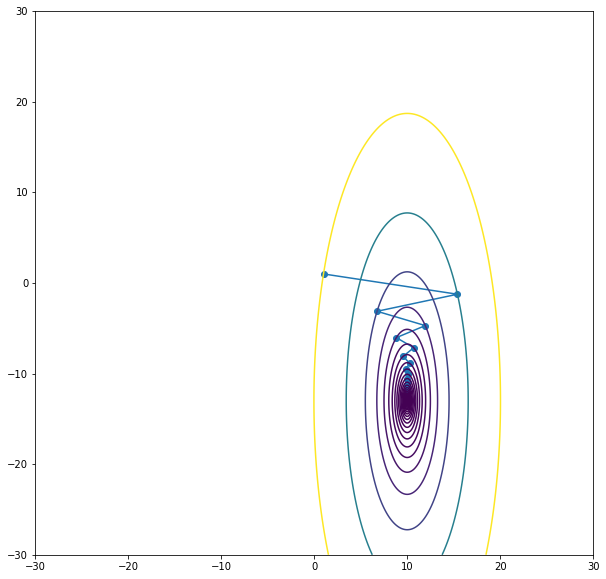

In [49]:
points = GradientDescending().find_min(g, initial=np.array([1, 1]), alpha=alpha, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, g([X, Y]), levels=sorted([g([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

896
896


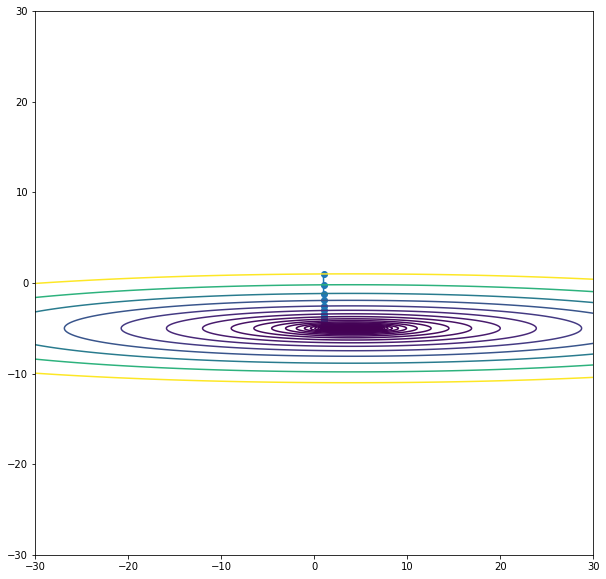

In [50]:
points = GradientDescending().find_min(h, initial=np.array([1, 1]), alpha=0.001, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, h([X, Y]), levels=sorted([h([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

16
16


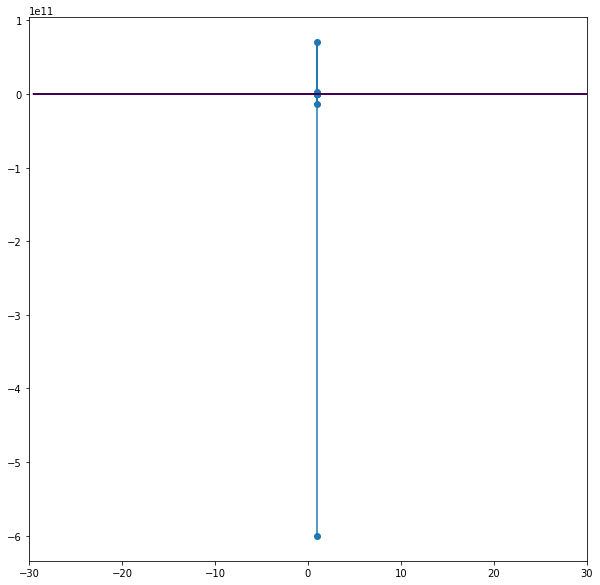

In [51]:
points = GradientDescending().find_min(k, initial=np.array([1, 1]), alpha=alpha, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, k([X, Y]), levels=sorted([k([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

In [52]:
delta = 50
gama = 3
dzeta = 0.5

12
[12, 636, 0]


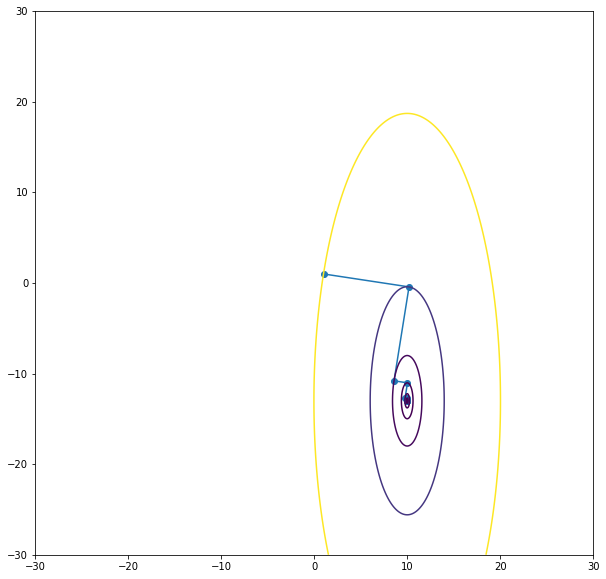

In [53]:
points = DichtGradientDescending().find_min(g, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, g([X, Y]), levels=sorted([g([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

5
[5, 351, 0]


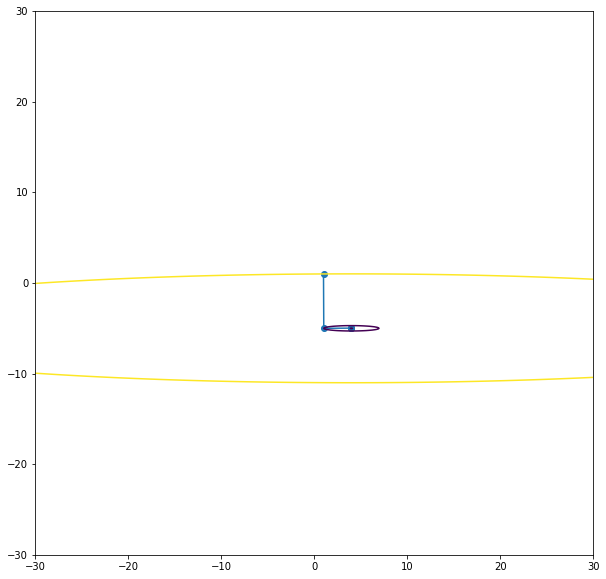

In [54]:
points = DichtGradientDescending().find_min(h, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, h([X, Y]), levels=sorted([h([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

2
[2, 114, 0]


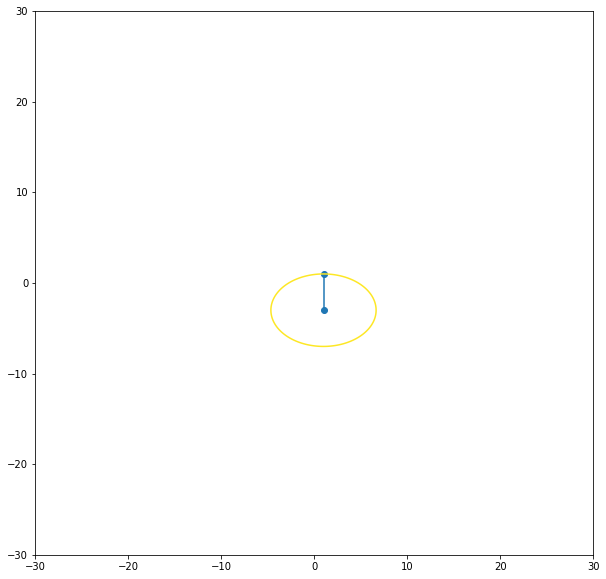

In [55]:
points = DichtGradientDescending().find_min(k, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, k([X, Y]), levels=sorted([k([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

12
[12, 489, 0]


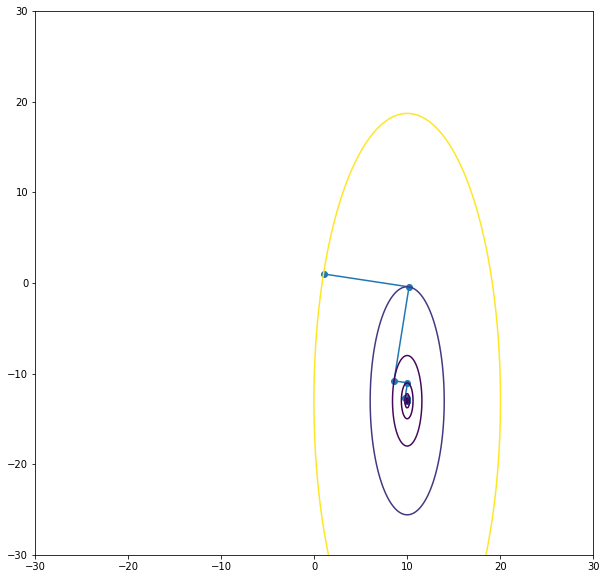

In [56]:
points = DichtGradientDescending().find_min(g, initial=np.array([1, 1]), alpha=gama, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, g([X, Y]), levels=sorted([g([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

5
[5, 273, 0]


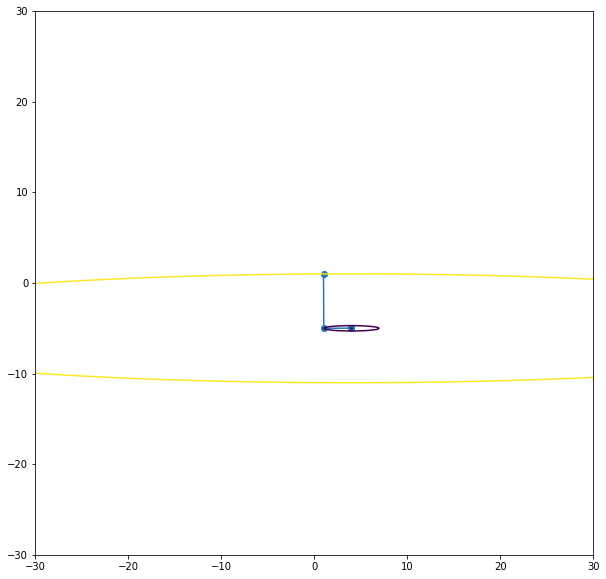

In [57]:
points = DichtGradientDescending().find_min(h, initial=np.array([1, 1]), alpha=gama, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, h([X, Y]), levels=sorted([h([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

2
[2, 87, 0]


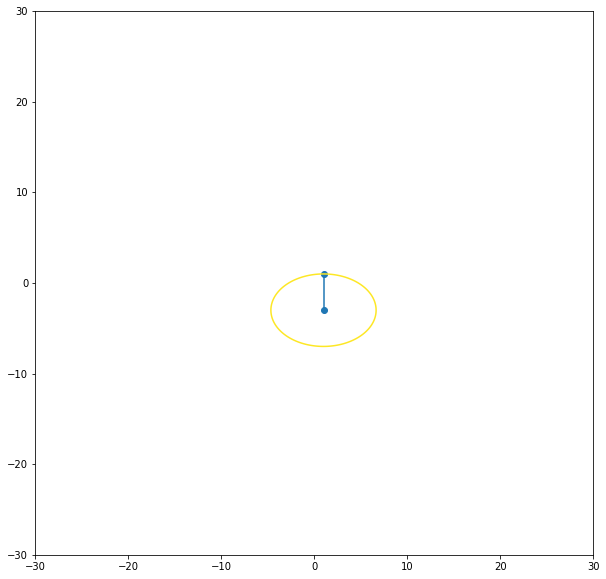

In [58]:
points = DichtGradientDescending().find_min(k, initial=np.array([1, 1]), alpha=gama, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, k([X, Y]), levels=sorted([k([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

40
[40, 240918, 0]


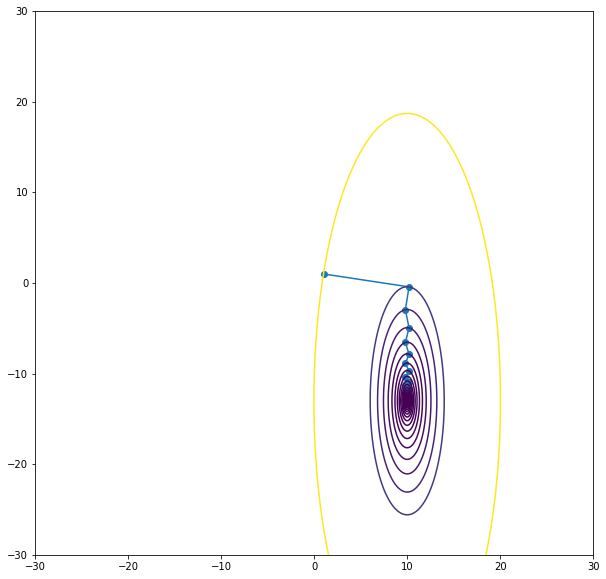

In [59]:
points = DichtGradientDescending().find_min(g, initial=np.array([1, 1]), alpha=dzeta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, g([X, Y]), levels=sorted([g([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

4
[4, 210, 0]


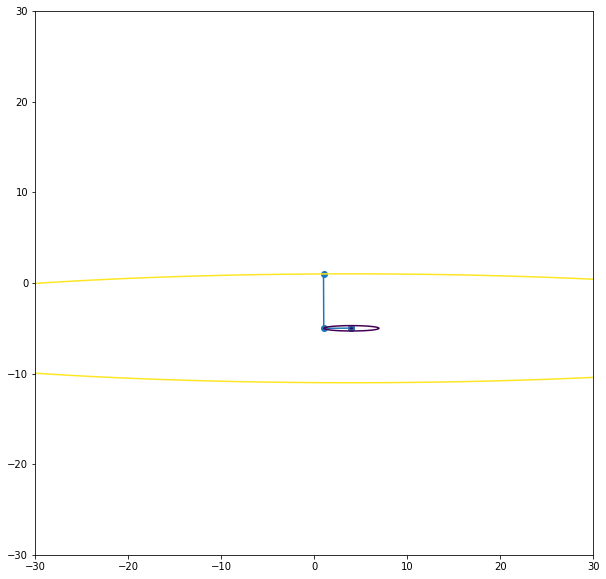

In [60]:
points = DichtGradientDescending().find_min(h, initial=np.array([1, 1]), alpha=dzeta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, h([X, Y]), levels=sorted([h([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

2
[2, 72, 0]


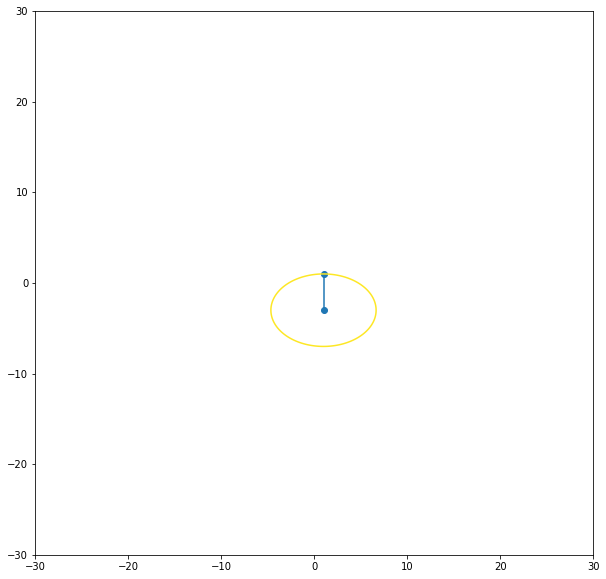

In [61]:
points = DichtGradientDescending().find_min(k, initial=np.array([1, 1]), alpha=dzeta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, k([X, Y]), levels=sorted([k([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

49
[49, 0, 0]


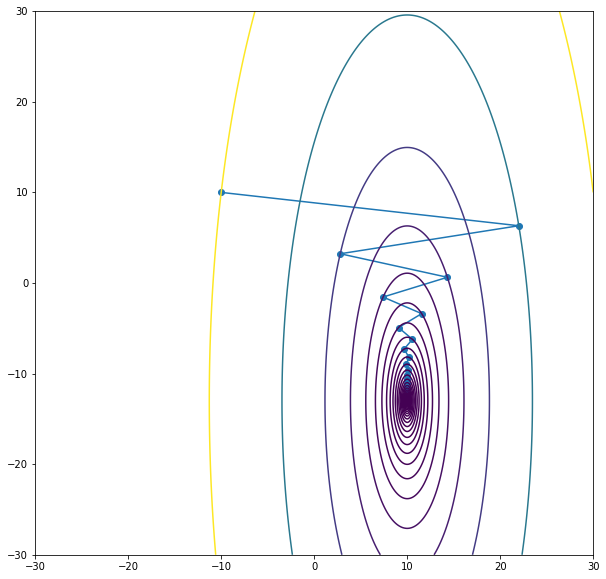

In [62]:
points = GradientDescending().find_min(g, initial=np.array([-10, 10]), alpha=alpha, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, g([X, Y]), levels=sorted([g([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

1666
[1666, 0, 0]


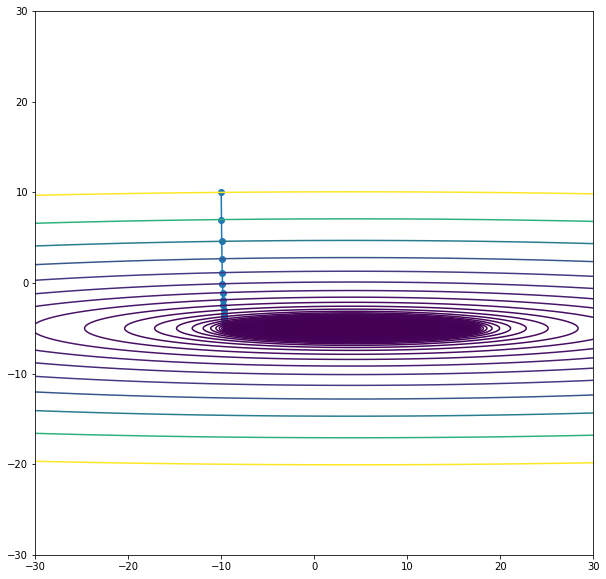

In [63]:
points = GradientDescending().find_min(h, initial=np.array([-10, 10]), alpha=0.001, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, h([X, Y]), levels=sorted([h([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

15
[15, 0, 0]


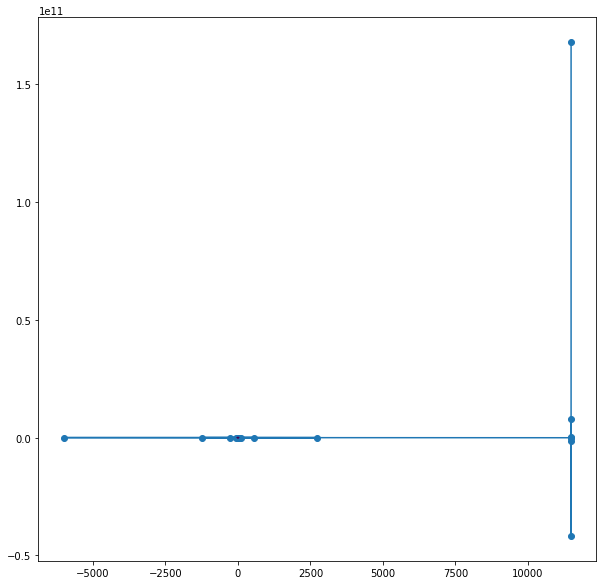

In [64]:
points = GradientDescending().find_min(k, initial=np.array([-10, 10]), alpha=alpha, max_iterations=700)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, k([X, Y]), levels=sorted([k([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

In [65]:
l1 = 1.5
l2 = 0.5

def gl1(x):
  return 2*((x[0]*l1) - 10)**2 + 0.2*((x[1]*l1) + 13)**2 + 3
  
def hl1(x):
  return (x[0]*l1 - 4)**2 + 100*(x[1]*l1 + 5)**2
  
def kl1(x):
  return 4*(x[0]*l1 - 1)**2 + 8*(x[1]*l1 + 3)**2 - 4

def gl2(x):
  return 2*((x[0]*l2) - 10)**2 + 0.2*((x[1]*l2) + 13)**2 + 3
  
def hl2(x):
  return (x[0]*l2 - 4)**2 + 100*(x[1]*l2 + 5)**2
  
def kl2(x):
  return 4*(x[0]*l2 - 1)**2 + 8*(x[1]*l2 + 3)**2 - 4

26
[26, 0, 0]


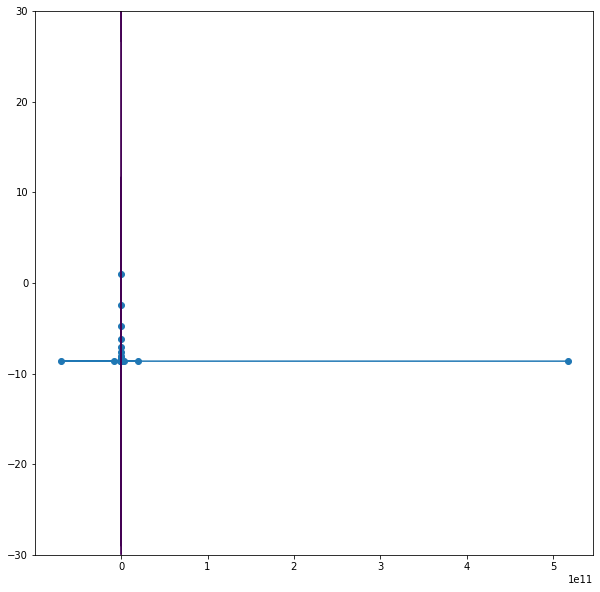

In [66]:
func = gl1
points = GradientDescending().find_min(func, initial=np.array([1, 1]), alpha=alpha, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

448
[448, 0, 0]


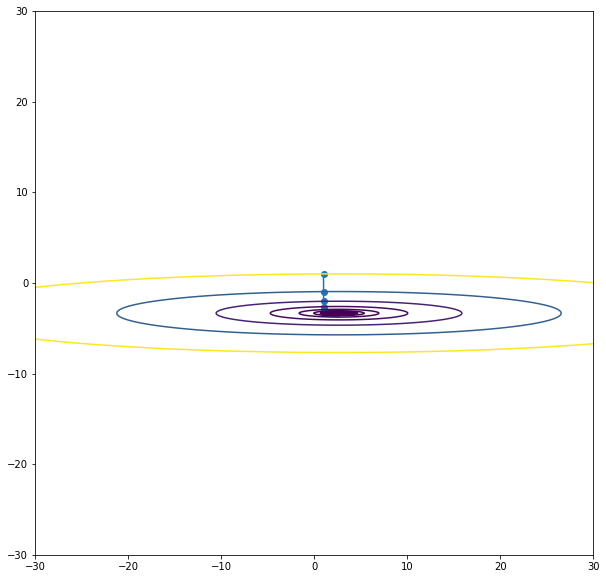

In [67]:
func = hl1
points = GradientDescending().find_min(func, initial=np.array([1, 1]), alpha=0.001, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

11
[11, 0, 0]


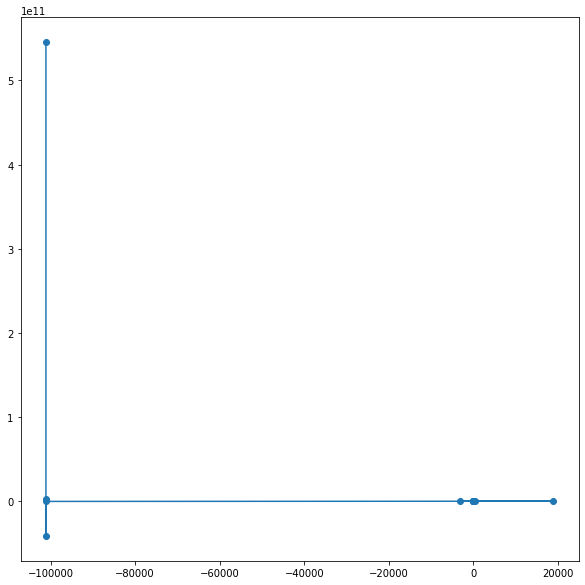

In [68]:
func = kl1
points = GradientDescending().find_min(func, initial=np.array([1, 1]), alpha=alpha, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

173
[173, 0, 0]


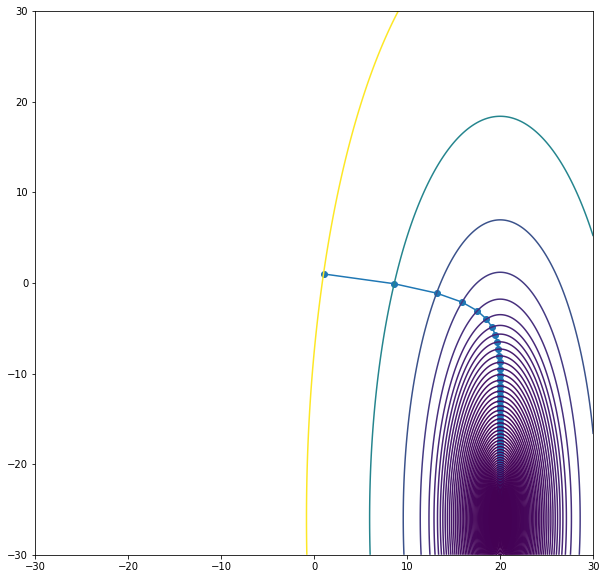

In [69]:
func = gl2
points = GradientDescending().find_min(func, initial=np.array([1, 1]), alpha=alpha, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt[0])

2506
[2506, 0, 0]


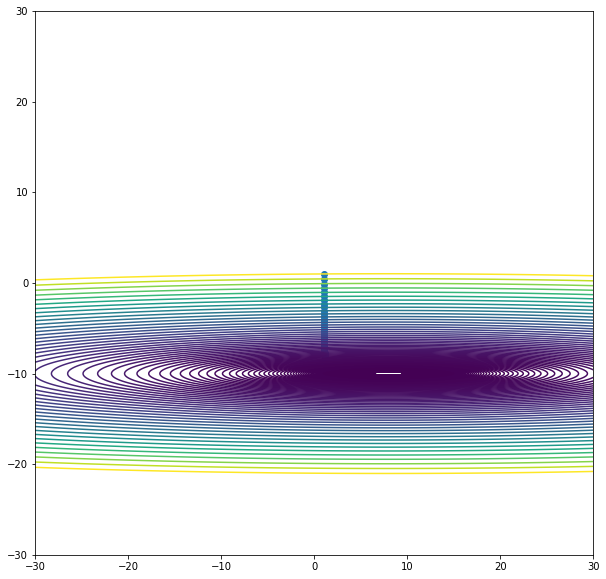

In [70]:
func = hl2
points = GradientDescending().find_min(func, initial=np.array([1, 1]), alpha=0.001, max_iterations=10000)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

20
[20, 0, 0]


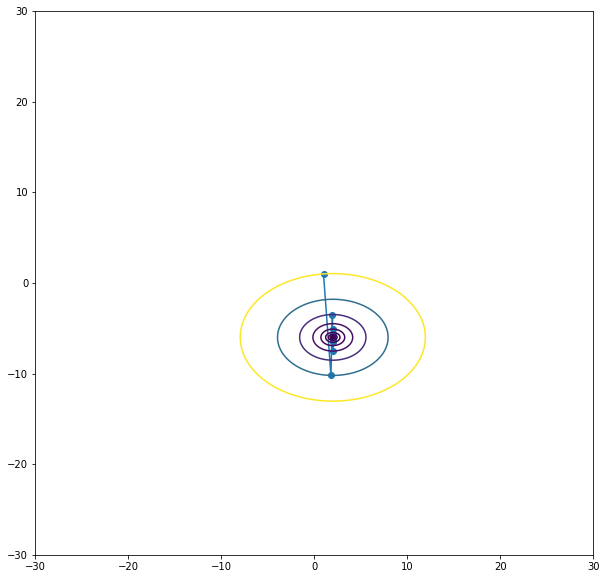

In [71]:
func = kl2
points = GradientDescending().find_min(func, initial=np.array([1, 1]), alpha=alpha, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

13
[13, 711, 0]


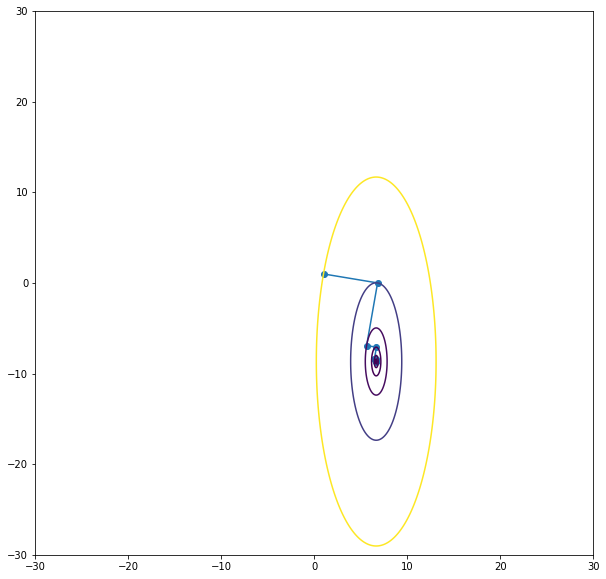

In [72]:
func = gl1
points = DichtGradientDescending().find_min(func, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

4
[4, 297, 0]


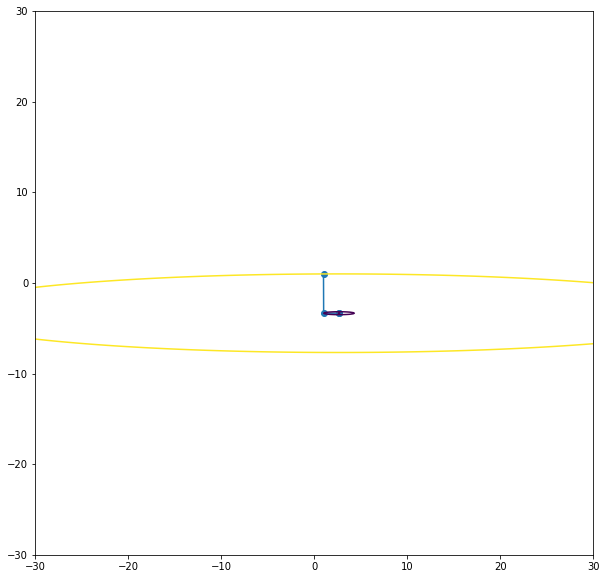

In [73]:
func = hl1
points = DichtGradientDescending().find_min(func, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

4
[4, 249, 0]


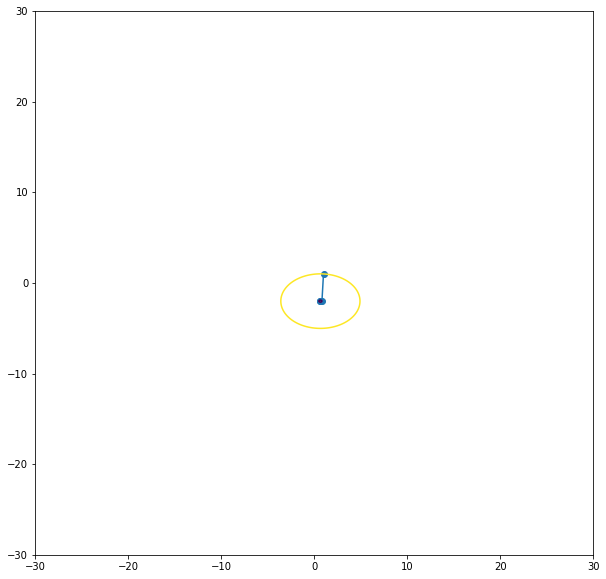

In [74]:
func = kl1
points = DichtGradientDescending().find_min(func, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
points = points.reshape(points.size // 2, 2)
#print(points)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(points.size // 2)
print(cnt)

7
[7, 405, 0]


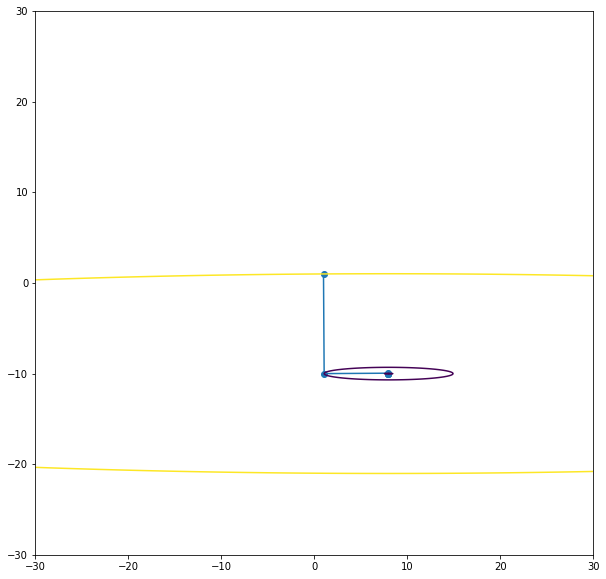

In [75]:
func = hl2
points = DichtGradientDescending().find_min(func, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

12
[12, 585, 0]


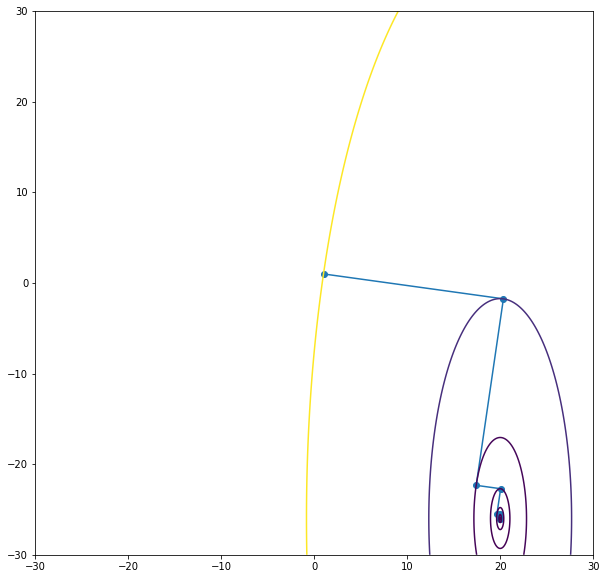

In [76]:
func = gl2
points = DichtGradientDescending().find_min(func, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

5
[5, 258, 0]


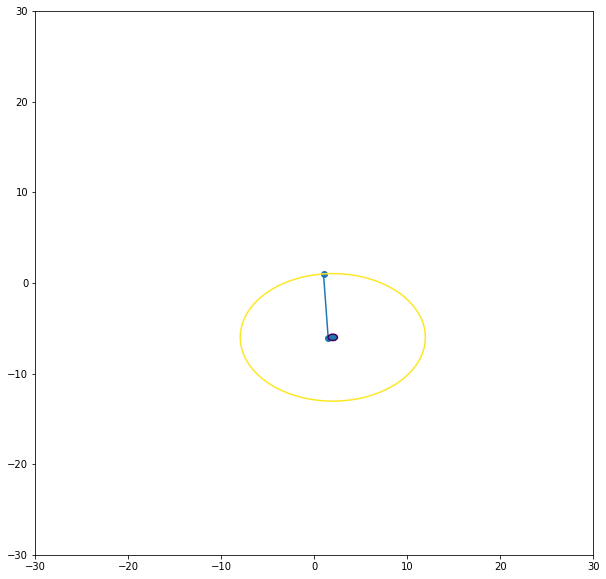

In [77]:
func = kl2
points = DichtGradientDescending().find_min(func, initial=np.array([1, 1]), alpha=delta, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, func([X, Y]), levels=sorted([func([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

45
[2341, 1752, 0]


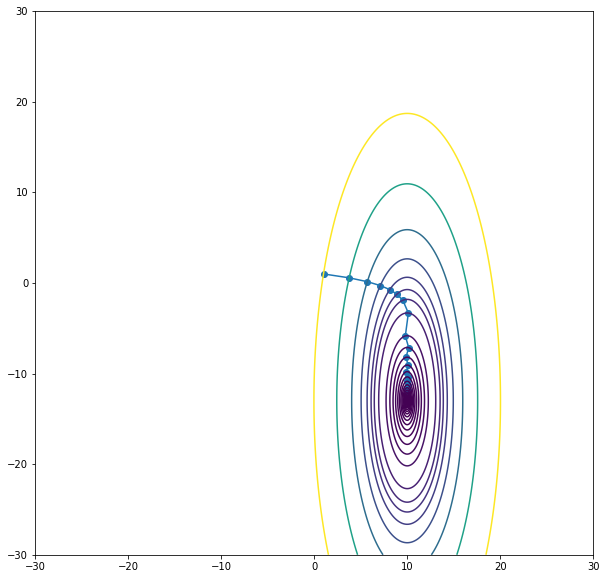

In [78]:
points = WolfGradientDescending().find_min(g, initial=np.array([1, 1]), alpha=0, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, g([X, Y]), levels=sorted([g([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

67
[2491, 2144, 0]


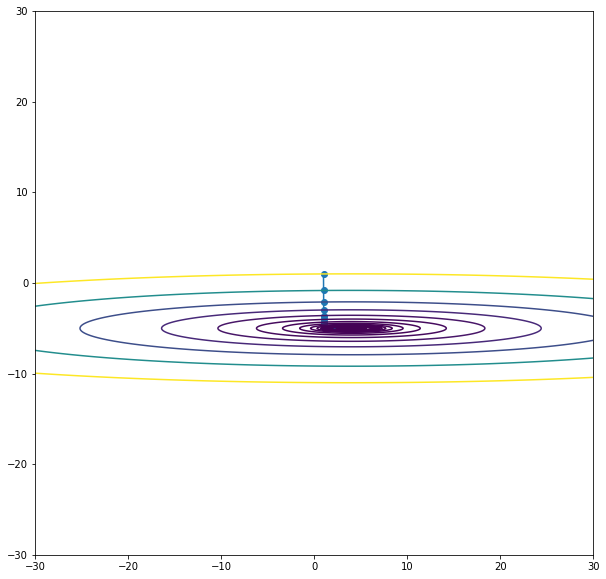

In [79]:
points = WolfGradientDescending().find_min(h, initial=np.array([1, 1]), alpha=0, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, h([X, Y]), levels=sorted([h([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)

21
[861, 672, 0]


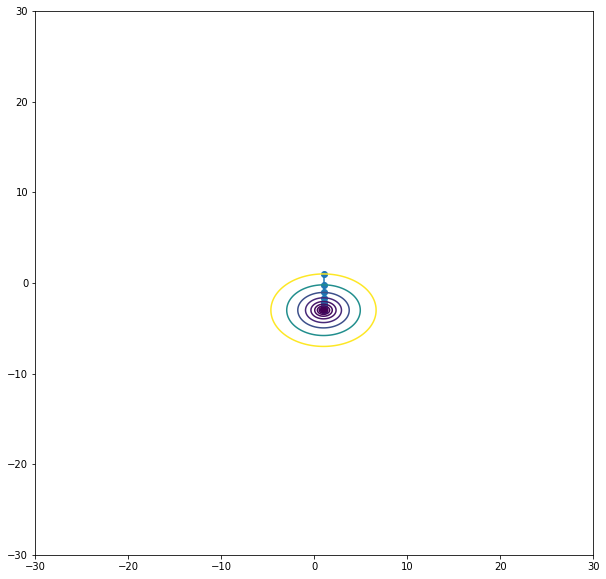

In [80]:
points = WolfGradientDescending().find_min(k, initial=np.array([1, 1]), alpha=0, max_iterations=max_iterations)
plt.plot(points[:, 0], points[:, 1], 'o-')
plt.contour(X, Y, k([X, Y]), levels=sorted([k([p[0], p[1]]) for p in points]))
print(len(points))
print(cnt)